In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt

np.random.seed(42000)


class material:
    def __init__(self,name:str,sigma_a:float,sigma_s:float,sigma_f:float,nu:float):
        
        self.name=name
        self.sigma_a=sigma_a
        self.sigma_s=sigma_s
        self.sigma_f=sigma_f
        self.nu=nu

        self.sigma_t=self.sigma_a+self.sigma_f+sigma_s


class source:
    def __init__(self,type:str,r:float):
        self.r=r     



def sample_initial_neutrons(number_of_neutrons,source:object):
    """ 
    will accept the number of neutrons and send their sampled x,y position. 
    
    """
    x=np.random.uniform(-source.r,source.r,size=number_of_neutrons)*np.cos(np.random.uniform(0,np.pi*2,size=number_of_neutrons))
    y=np.random.uniform(-source.r,source.r,size=number_of_neutrons)*np.sin(np.random.uniform(0,np.pi*2,size=number_of_neutrons))

    return x,y 






/usr/local/lib/python3.10/dist-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:


X_left=0
X_right=10

Y_up=10
Y_down=0

Nx=100
Ny=Nx

dx=(X_right-X_left)/Nx
dy=(Y_up-Y_down)/Ny

X = np.linspace(dx*0.5, (X_right-X_left) - 0.5*dx,Nx)
Y = np.linspace(dx*0.5, (Y_up-Y_down) - 0.5*dx,Ny)

X,Y=np.meshgrid(X,Y)

In [3]:
uo2=material(name='fuel',sigma_a=0.2,sigma_f=.3,sigma_s=3,nu=2.5)
h20=material(name='coolant',sigma_a=.5,sigma_f=0,sigma_s=0.7,nu=0)

source=source(type='neutron',r=2)

fuel_rad=5

def find_mat(pos):

    x=pos[0]
    y=pos[1]
    
    if x**2+y**2<=fuel_rad:
        return uo2
    elif(x**2+y**2>fuel_rad) and abs(x)<=X_right and abs (y)<=Y_up :
        return h20
    else:
        return None
    
def find_surface_intersection_point(pos,pos_new):

    a=pos[0]
    b=pos[1]
    a_new=pos_new[0]
    b_new=pos_new[1]

    tol=1e-7

    for i in range (100):
        x=(a+a_new)/2
        y=(b+b_new)/2

        if abs(x**2+y**2-fuel_rad)<tol:
            break
        elif (x**2+y**2-fuel_rad)>0:
            a_new=x
            b_new=y
        elif (x**2+y**2-fuel_rad)<0:
            a=x
            b=y
    return x,y

In [4]:
active_batch=100
inactive_batch=10
no_of_gen_per_batch=2
number_of_neutrons=100

total_batch=active_batch+inactive_batch

scalar_flux = np.zeros((Nx,Ny))
scalar_flux_tl = np.zeros_like (scalar_flux)
weights=np.ones(number_of_neutrons)

In [5]:

x,y=sample_initial_neutrons(number_of_neutrons=number_of_neutrons,source=source)

(-10.0, 10.0)

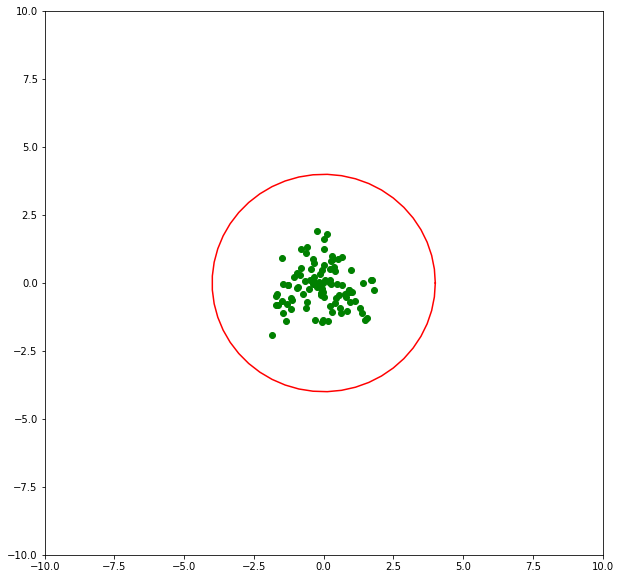

In [6]:
plt.figure(figsize=(10,10))
plt.scatter(x,y,color='g')
plt.plot(4*np.cos(np.linspace(0,np.pi*2)),4*np.sin(np.linspace(0,np.pi*2)),color='red')
plt.xlim(-10,10)
plt.ylim(-10,10)

In [7]:

fission_sites_x=np.array([])
fission_sites_y=np.array([])

In [8]:
for batch in range (active_batch+inactive_batch):

    for g in range( no_of_gen_per_batch):

        for n in range(number_of_neutrons):

            mu=np.random.rand()*2-1
            eta=np.sqrt(1-mu**2)
            initail_dir=np.array([mu,eta])

            weight=weights[n]
            weights_old=weights.copy()
            alive=True
            pos=np.array([x[n],y[n]])


            
            while alive: 

                ''' sample distance first'''
                material=find_mat(pos)
                rand_num=np.random.rand()               
                l=-np.log(rand_num)/material.sigma_t

                """ check it the from that position the particle will cross any boundray?"""
                if find_mat(pos)!=find_mat(pos+l*initail_dir):

                    '''calculating the boundary crossing position'''
                    x_,y_=find_surface_intersection_point(pos=pos,pos_new=(pos+l*initail_dir))
                    l=np.sqrt((x_-pos[0])**2+(y_-pos[1])**2)
                    
                
                #sample the angualar direction as well
                

                if find_mat(pos)==None: 
                    alive=False
                else: 
                    '''
                      now we sample the direction 
                    '''
                    reaction_type=np.random.choice(['scattering','capture','fission'],p=[material.sigma_s/material.sigma_t,material.sigma_a/material.sigma_t,material.sigma_f/material.sigma_t])
                    if reaction_type=='scattering':
                        '''
                            change particle direction by sampling new mu and eta for new direction 
                        '''
                        mu=np.random.rand()*2-1
                        eta=np.sqrt(1-mu**2)
                        pos=pos+l*initail_dir
                        initail_dir=np.array([mu,eta])
                        
                        weight=weight*material.sigma_s
                        x_cell_index=int(pos[0]/dx)
                        y_cell_index=int(pos[1]/dy)

                        scalar_flux[x_cell_index][y_cell_index]=scalar_flux[x_cell_index][y_cell_index]+weight*l

                    elif reaction_type=='capture':
                        ''' 
                            kill the particle
                        '''
                        weight=weight*material.sigma_a
                        alive=False

                        np.append(fission_sites_x,pos[0])
                        np.append(fission_sites_y,pos[1])
                        
                    else: 
                        ''' as there are only three choice the other one will be fission 

                            1. adjust particle weight and kill the particle
                            2. keep the record of the fissoion sites 
                            3. keep the record of the fission site's weights 
                        '''
                        weight=weight*material.sigma_f*material.nu
                        
                        fission_sites_x=np.append(fission_sites_x,pos[0])
                        fission_sites_y=np.append(fission_sites_y,pos[1])

                        alive=False
            
            weights[n]=weight


        for i in range (number_of_neutrons):
            x[i]=random.choice(fission_sites_x)
            y[i]=random.choice(fission_sites_y)

        np.delete(fission_sites_x,0)
        np.delete(fission_sites_y,0)

    print(sum(weights/weights_old))   
    weights=np.ones(number_of_neutrons) 
    


281.25
99.75
103.5
99.6
101.25
105.75
99.2
864.4499999999999
103.5
99.245
9940.5
99.5
112.5
99.35
105.75
1195841.25
101.25
127.35
119.25
100.8
101.25
105.75
139.5
102.24135
115.2
103.5
99.1715
184.04999999999998
105.75
119.25
99.2
99.75
101.25
100.5
139.5
2461.9441499999994
220.5
159.74999999999997
99.75
99.75
102.24135
108.72404999999999
99.75
108.45
99.6
634.8149999999999
1192.5000000000002
99.6
99.2
100.5435
105.75
105.75
132959.25
101.205
1192.4999999999998
281.25
102.33534915
99.0588245
99.38134158615
100.05
2395.35
104.4
634.8149999999999
645.7499999999999
99.35
140.6745
100.5435
100.8
99.5
101.25
100.5
2395.35
119.25
127.35
1743392299.5
105.615
99.75
115.2
184.04999999999998
119.25
99.2
354.15
99.75
99.2
99.084035
99.75
119.25
220.5
119.25
158.535
112.5
108.45
108.45
99.2
139.5
101.25
184.05
115.2
139.5
99.2
112.5
99.75
184.05
99.6
220.5
105.75
3379.4999999999995
139.5
105.75
139.5


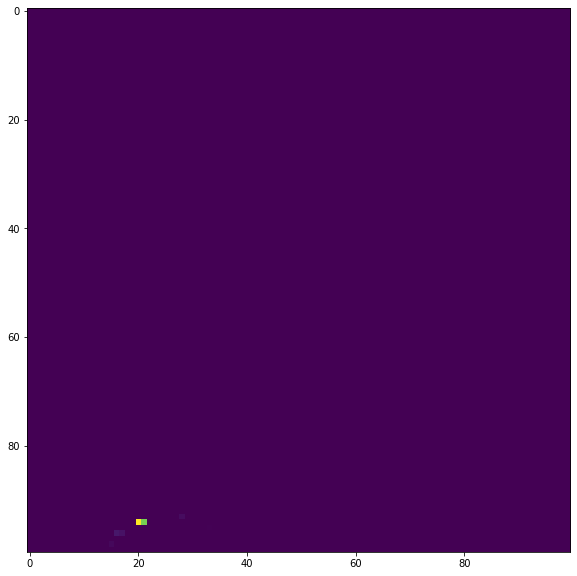

In [9]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.imshow(scalar_flux)

In [10]:
weights

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])